<img style="float:right" src="images/logo_va.png" /> 
# Visione Artificiale
## Esercitazione: Deep learning

### Sommario
* Utilizzo di una rete neurale già addestrata in OpenCV
* Predisposizione dell'input
* Interpretare l'ouput di YOLO v3
* Non-maximum suppression

Iniziamo con l'importazione dei moduli che ci serviranno: `NumPy`, `OpenCV`, `va`. Importiamo anche la funzione `interact` di Jupyter.

In [1]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

In questa esercitazione utilizzeremo una DNN per object-detection: YOLO v3 \[1\]. Prima di tutto è necessario scaricare il file con i pesi della rete già addestrata (247 MB) da questo indirizzo: https://pjreddie.com/media/files/yolov3.weights. Il file andrà salvato nella sottocartella "dnn", dove è già presente "yolov3.cfg" (configurazione della rete) e "yolov3.txt" (nomi delle classi degli oggetti su cui è stata addestrata).


\[1\] Joseph Redmon and Ali Farhadi, [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767), 2018.

<img style="float:left" src="images/ar.png" />**Esercizio 1** - Utilizzando la funzione OpenCV `cv.dnn.readNet()`, caricare da file la rete neurale, passando il path "dnn/yolov3.weights" come `model` e il path "dnn/yolov3.cfg" come `config`: memorizzare il valore di ritorno (il riferimento alla rete in memoria) in una variabile `net`. Leggere quindi i nomi delle 80 classi dal file di testo "dnn/yolov3.txt", che contiene un nome per ogni riga: memorizzare i nomi in una lista Python di stringhe `class_names`: i nomi delle classi non devono contenere il carattere new line ('\n').  
Suggerimenti: ci sono vari modi per leggere un file di testo in Python, si possono trovare molti esempi su Internet. Fra i modi più semplici, c'è l'utilizzo della funzione `open()`, che restituisce uno `stream`, che a sua volta mette a disposizione il metodo `read()`; infine può essere utile il metodo `splitlines()` della classe `str`.

In [2]:
# --- Svolgimento Esercizio 1: Inizio --- #
net=cv.dnn.readNet('dnn/yolov3.weights','dnn/yolov3.cfg')
path="dnn/yolov3.txt"

#read legge tutto il file come monoriga
class_names = open(path).read().splitlines()

# --- Svolgimento Esercizio 1: Fine --- #

In [3]:
class_names #vedo che ho dentro

['persona',
 'bicicletta',
 'auto',
 'moto',
 'aereo',
 'bus',
 'treno',
 'camion',
 'nave',
 'semaforo',
 'idrante',
 'stop',
 'parchimetro',
 'panchina',
 'volatile',
 'gatto',
 'cane',
 'cavallo',
 'pecora',
 'mucca',
 'elefante',
 'orso',
 'zebra',
 'giraffa',
 'zaino',
 'ombrello',
 'borsa',
 'cravatta',
 'valigia',
 'frisbee',
 'sci',
 'snowboard',
 'pallone',
 'aquilone',
 'mazza da baseball',
 'guanto da baseball',
 'skateboard',
 'tavola da surf',
 'racchetta',
 'bottiglia',
 'bicchiere',
 'tazza',
 'forchetta',
 'coltello',
 'cucchiaio',
 'ciotola',
 'banana',
 'mela',
 'sandwich',
 'arancia',
 'broccoli',
 'carota',
 'hot dog',
 'pizza',
 'ciambella',
 'torta',
 'sedia',
 'divano',
 'pianta',
 'letto',
 'tavolo',
 'water',
 'tv',
 'laptop',
 'mouse',
 'telecomando',
 'tastiera',
 'telefono',
 'microonde',
 'forno',
 'tostapane',
 'lavello',
 'frigorifero',
 'libro',
 'orologio',
 'vaso',
 'forbici',
 'orsacchiotto',
 'asciugacapelli',
 'spazzolino']

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente esegue alcuni controlli sui dati.

In [4]:
va.test_dnn_1(net, class_names)

Nomi delle classi,Numero di livelli della rete
,


<img style="float:left" src="images/ar.png" />**Esercizio 2** - In previsione di dover disegnare con colori diversi le posizioni di oggetti di classi diverse in un'immagine, creare una lista `class_colors` di colori, dove il colore $i-$esimo è una tupla $(B_i, G_i, R_i)$ corrispondente ai seguenti valori HSV: $H_i = (i \cdot 29)\ mod\ 180, S_i=200, V_i=255$. I valori sono espressi negli stessi range utilizzati in OpenCV: $H\in[0,180), S\in[0,255], V\in[0,255]$. In sostanza l'obiettivo dell'esercizio è ottenere una lista di colori in formato BGR, con saturazione e luminosità costanti e con lo hue di ogni colore ruotato di 58° rispetto a quello del precedente.  
Suggerimento: una soluzione relativamente semplice consiste nell'utilizzare la funzione OpenCV per convertire immagini da HSV a BGR, facendo però attenzione al fatto che il risultato non deve essere un'immagine o una lista di immagini, ma una lista di tuple (B, G, R).

In [7]:
np.array((100,200,255), np.uint8).reshape(1,1,3)
#creo un immagine coi 3 canali hsv

array([[[100, 200, 255]]], dtype=uint8)

In [8]:
# --- Svolgimento Esercizio 2: Inizio --- #

hsv_images = [np.array(((i*29)%180,200,255), np.uint8).reshape(1,1,3)for i in range(len(class_names))]
#converto immagini in pixel bgr, poi tolgo le dimensioni inutili
#la trsformo in lista phyton e poi in tupla
class_colors=[tuple(cv.cvtColor(x, cv.COLOR_HSV2BGR).squeeze().tolist()) for x in hsv_images]
# --- Svolgimento Esercizio 2: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente controlla che tutti i colori siano corretti e li visualizza.

Controllo colori
""


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
,,,,,,,,,,,,,,,,,,,
20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
,,,,,,,,,,,,,,,,,,,
40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
,,,,,,,,,,,,,,,,,,,
60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
,,,,,,,,,,,,,,,,,,,

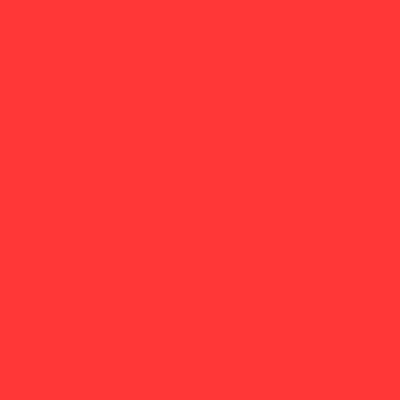
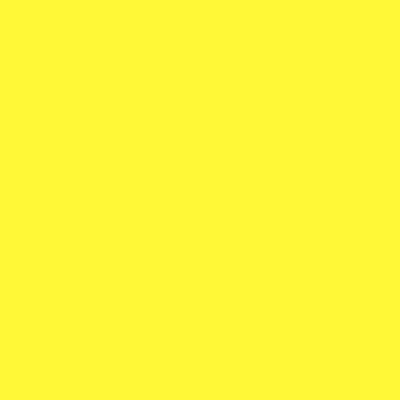
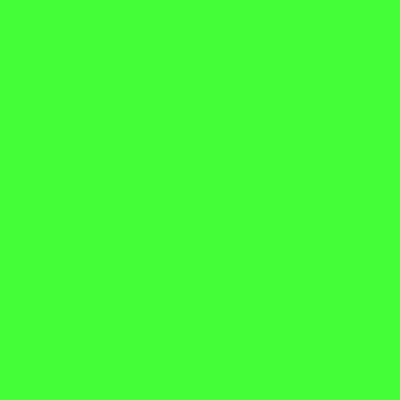
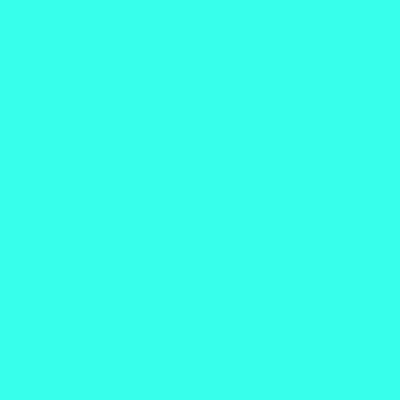
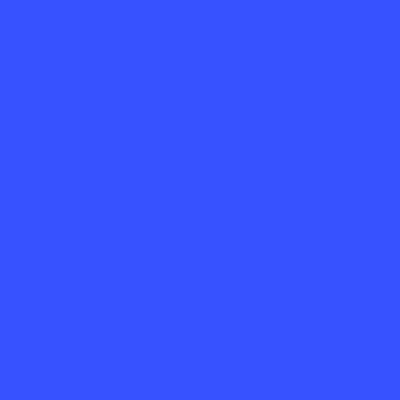
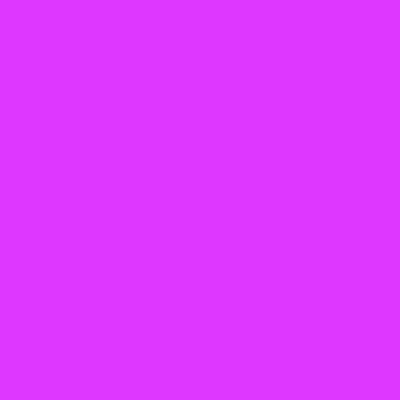
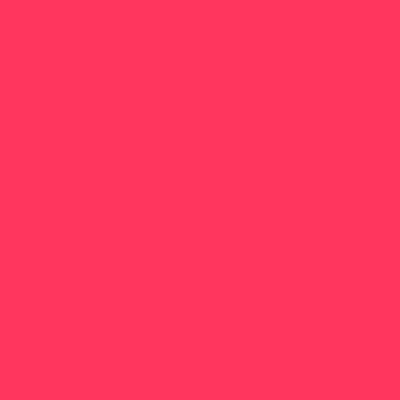
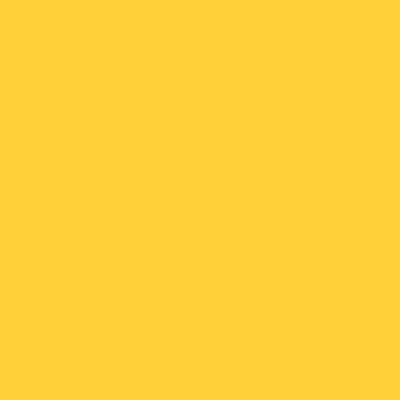
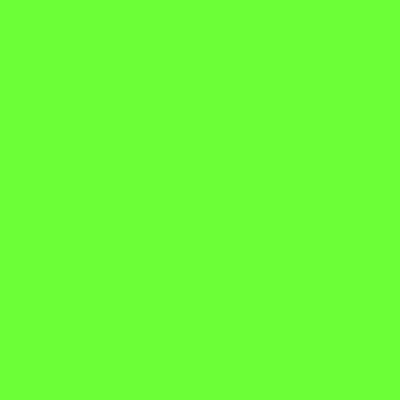
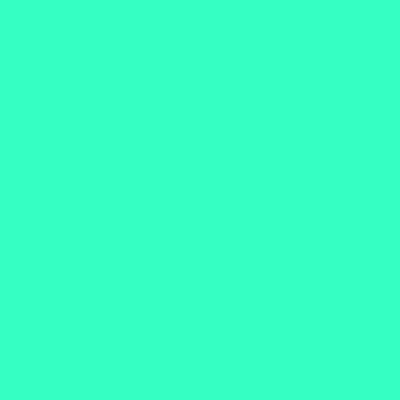
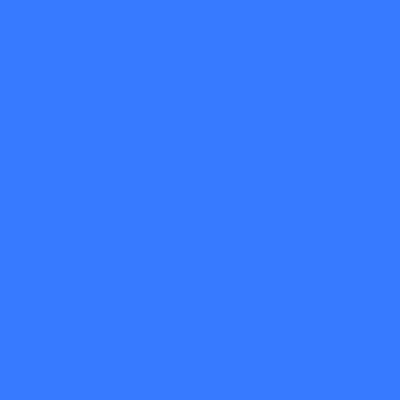
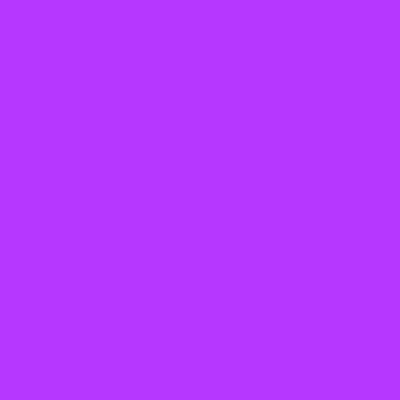
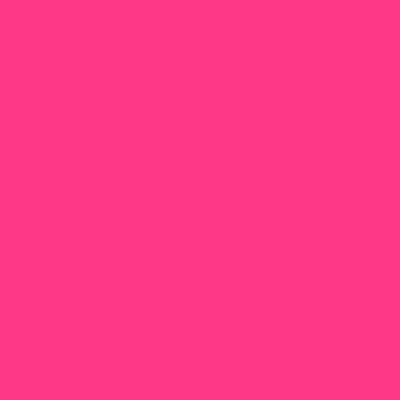
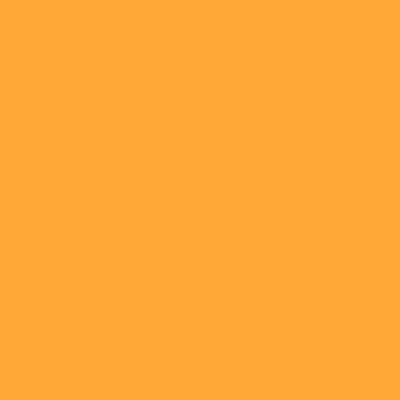
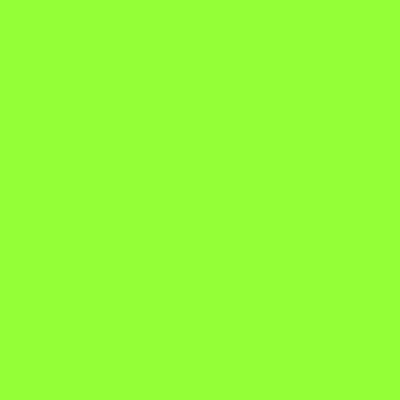
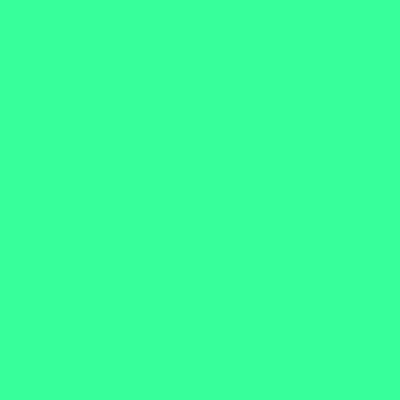
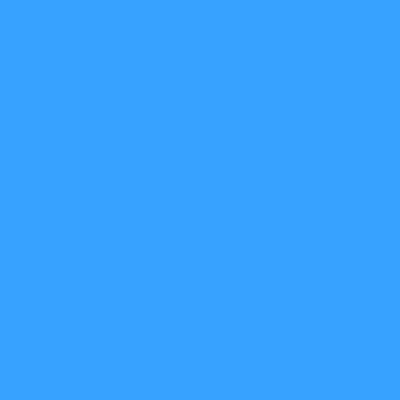
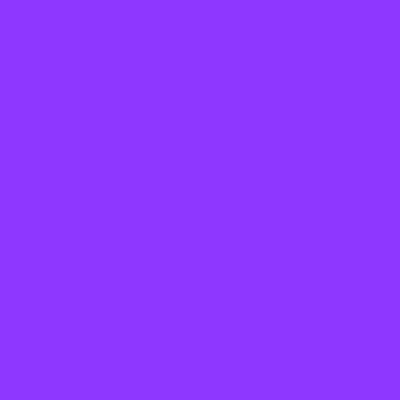
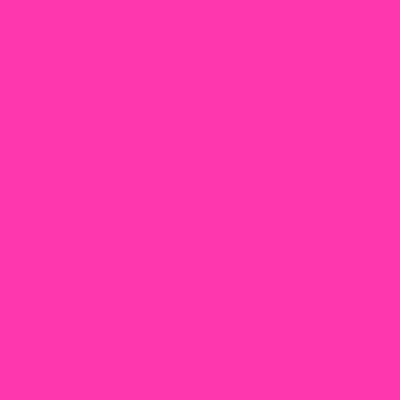
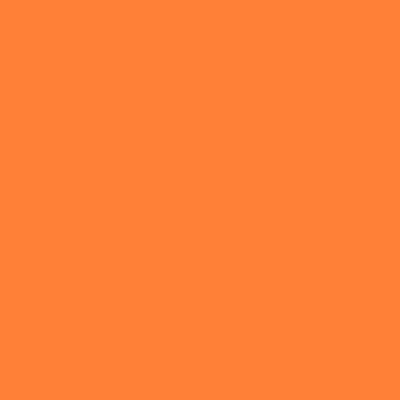
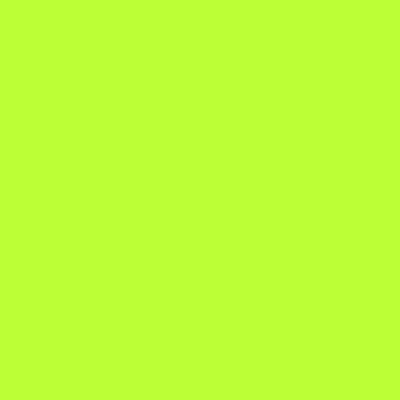
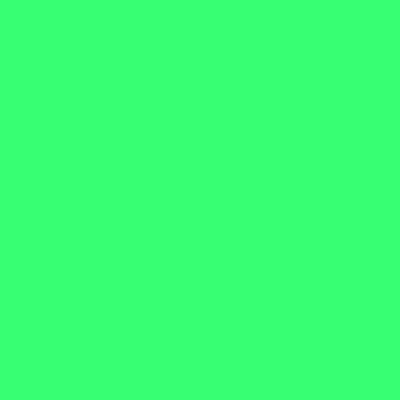
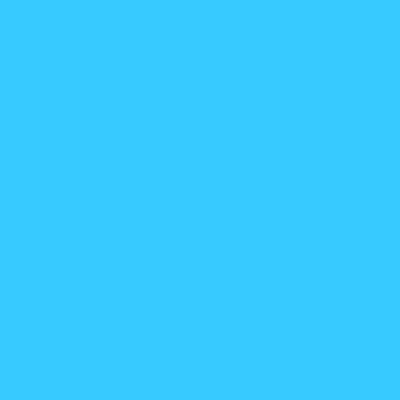
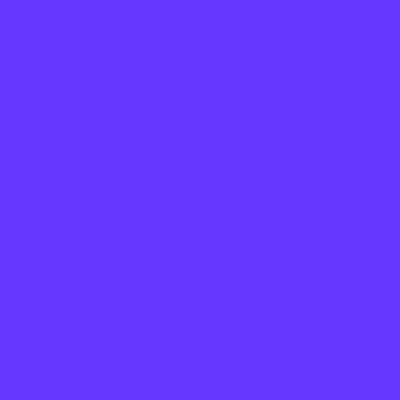
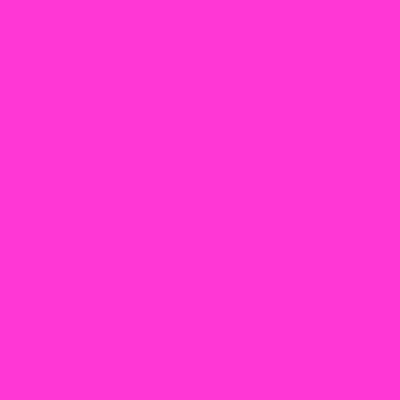
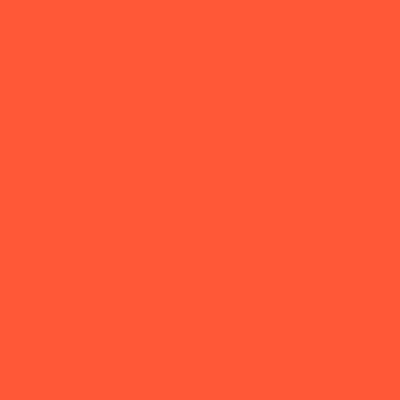
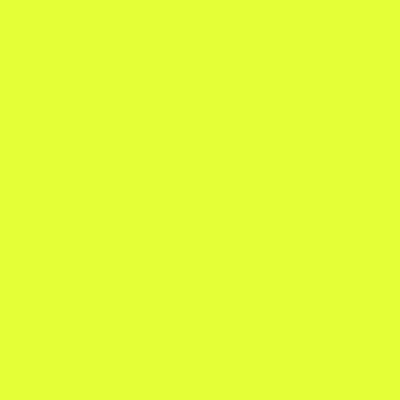
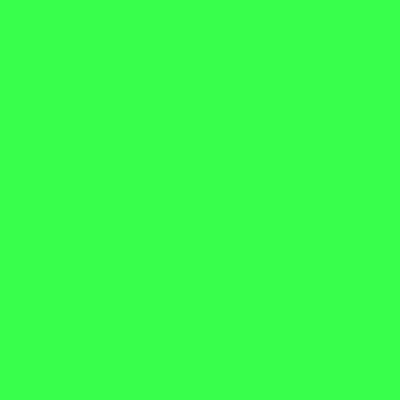
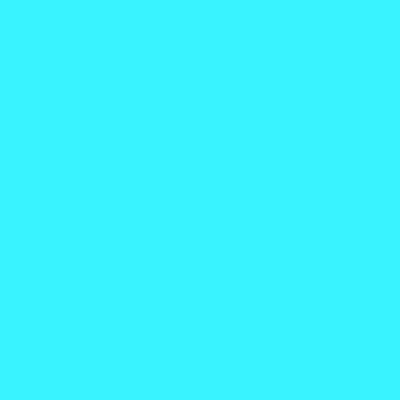
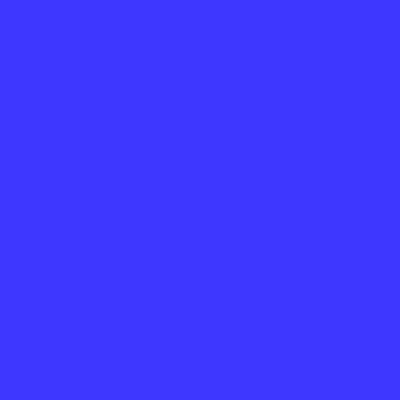
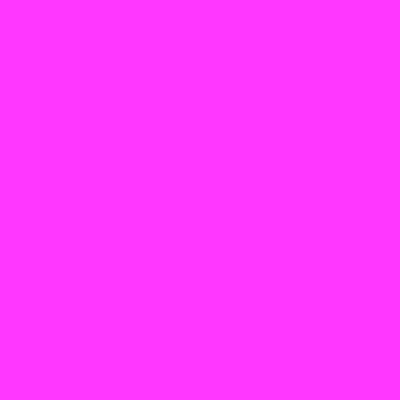
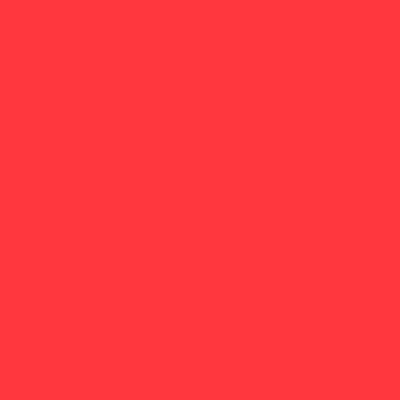
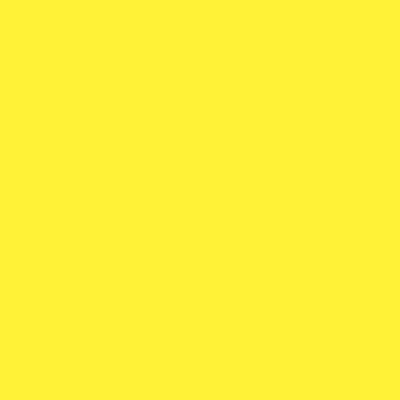
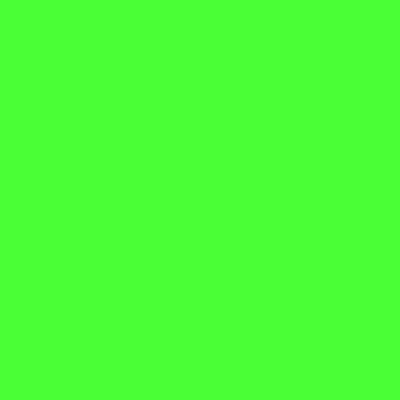
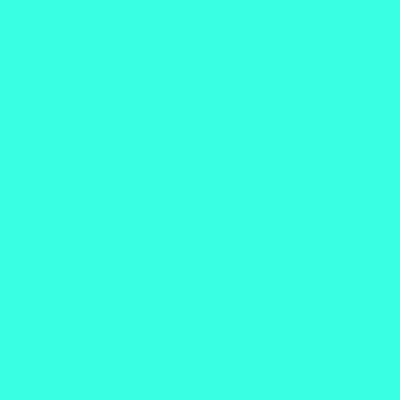
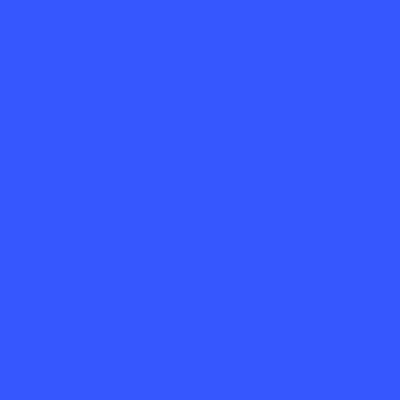
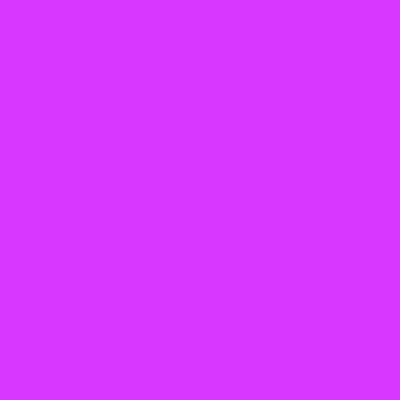
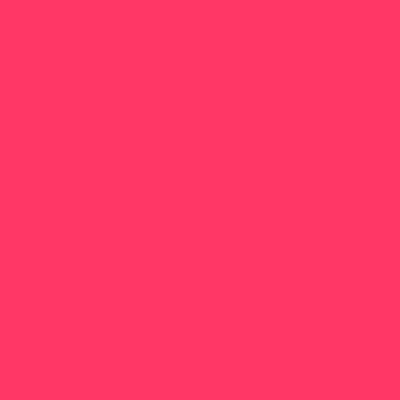
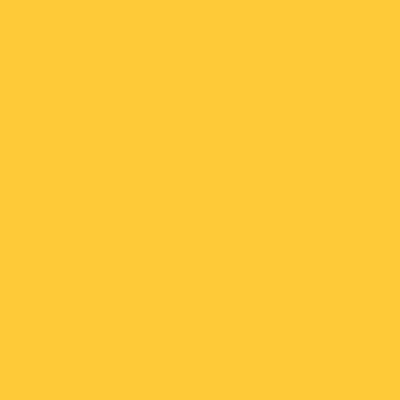
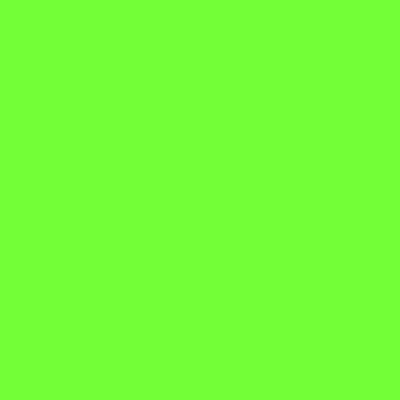
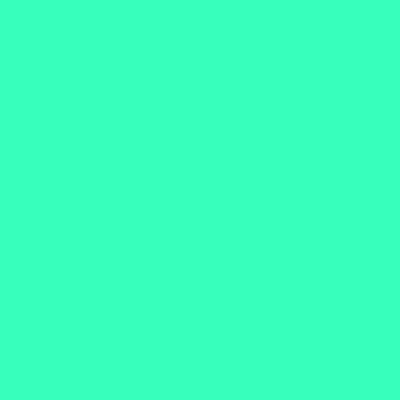
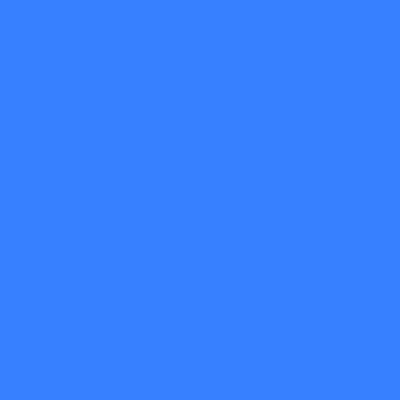
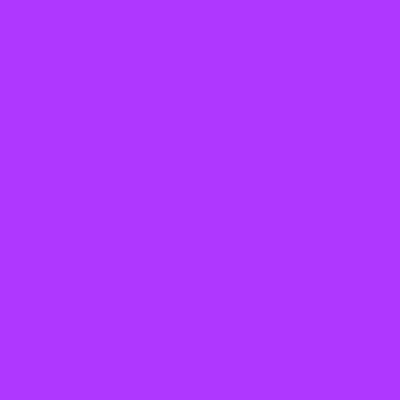
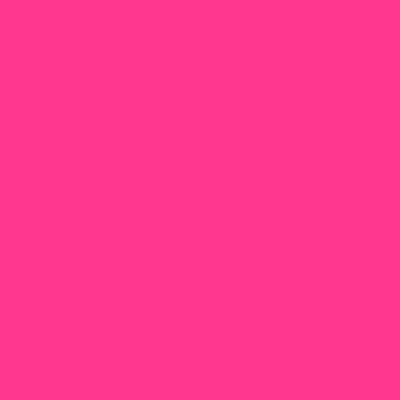
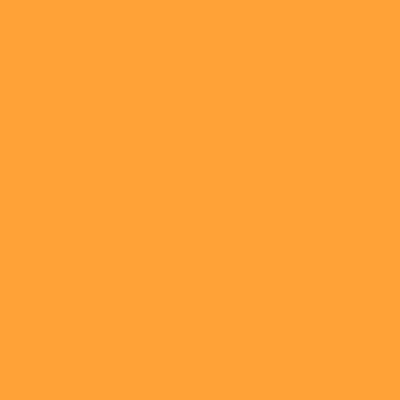
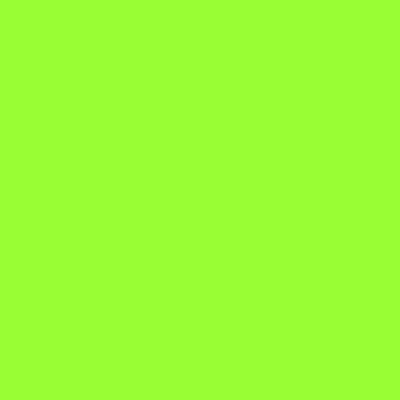
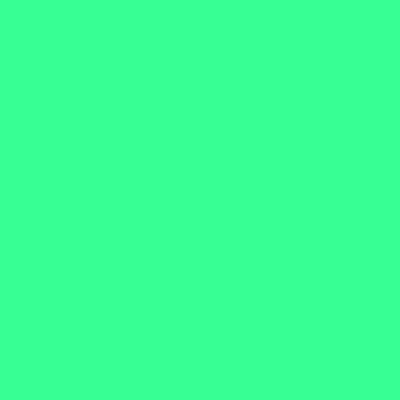
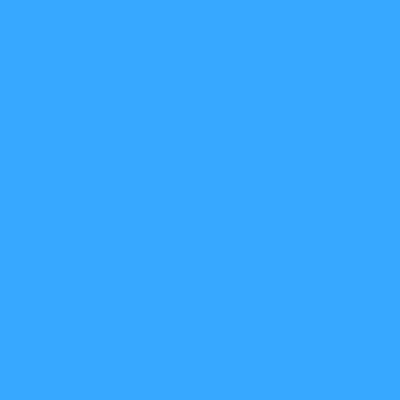
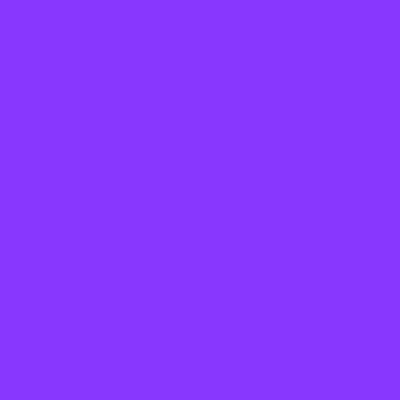
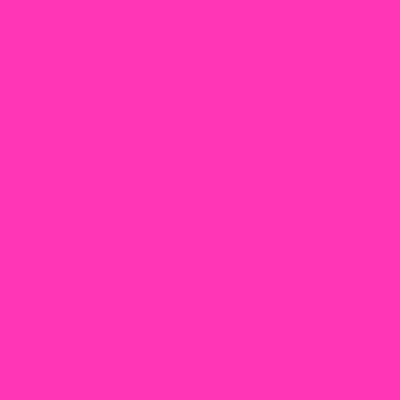
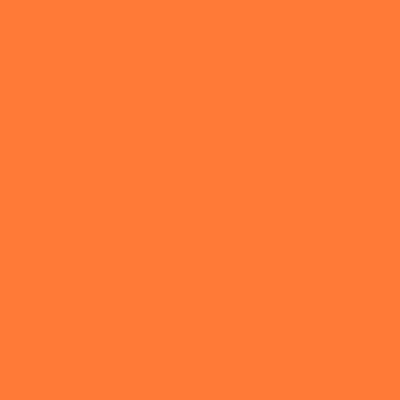
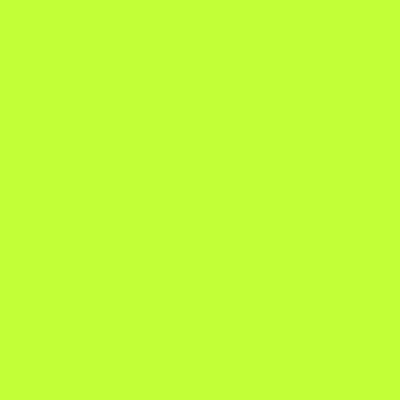
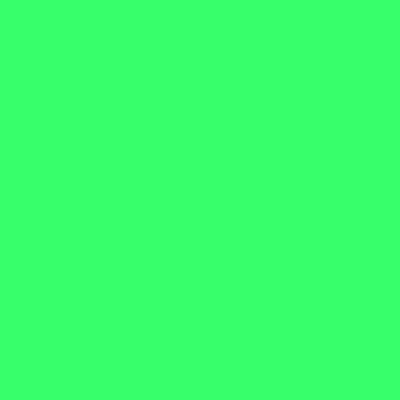
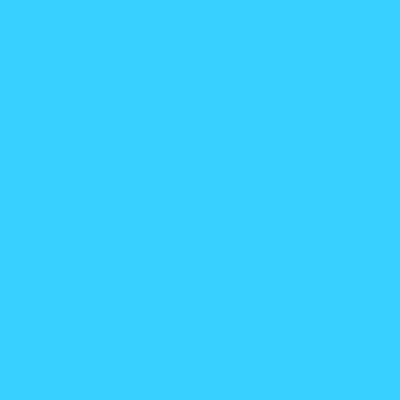
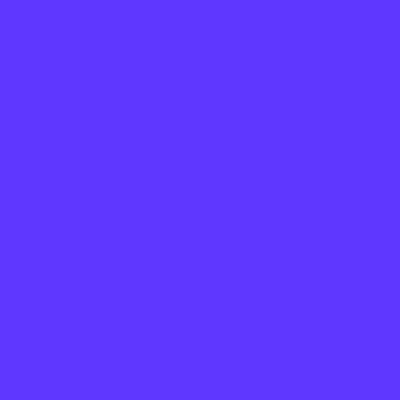
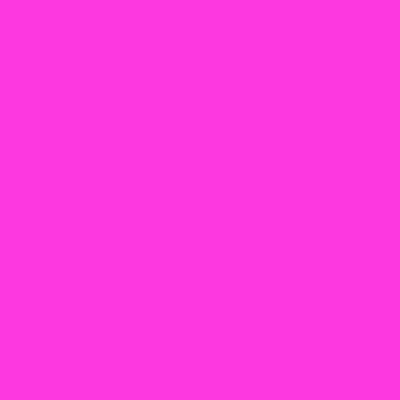
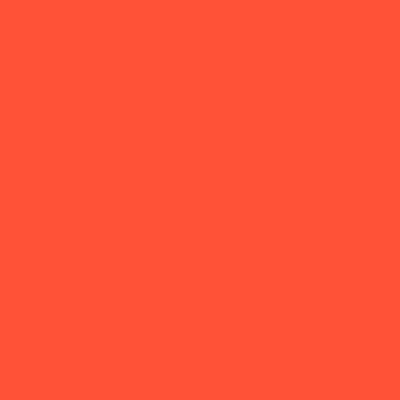
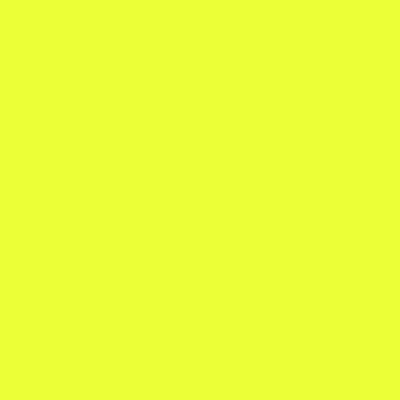
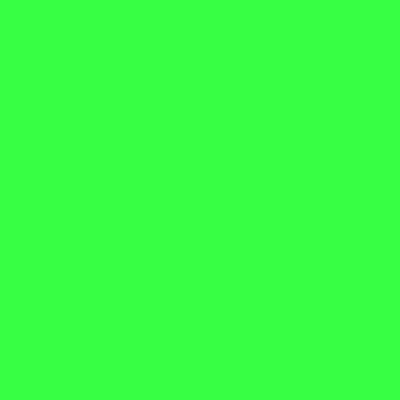
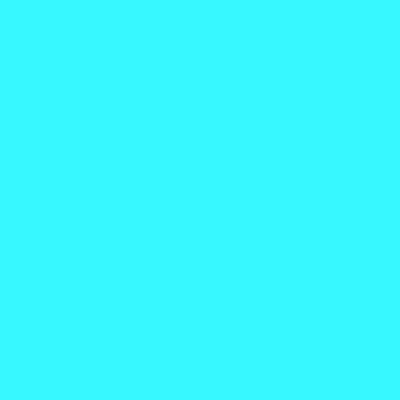
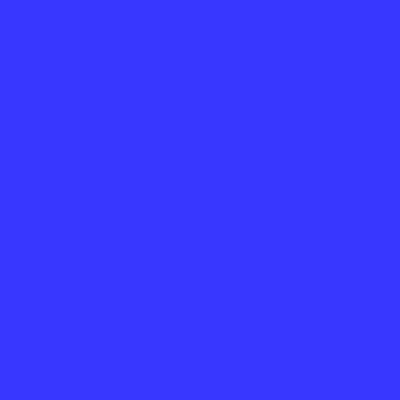
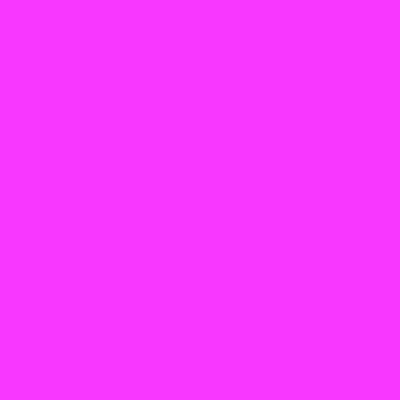
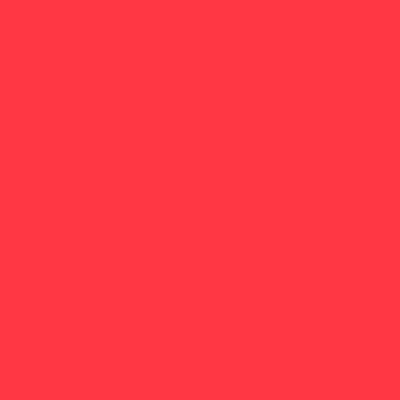
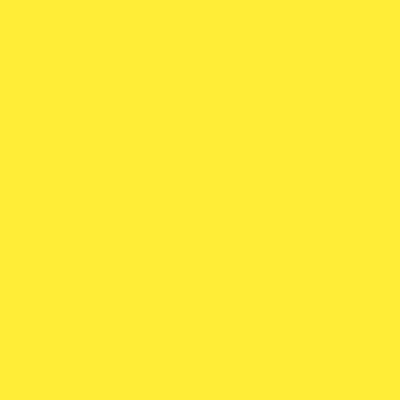
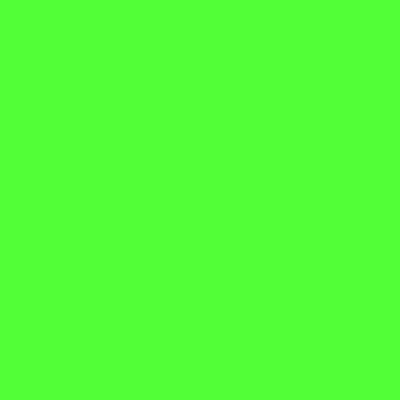
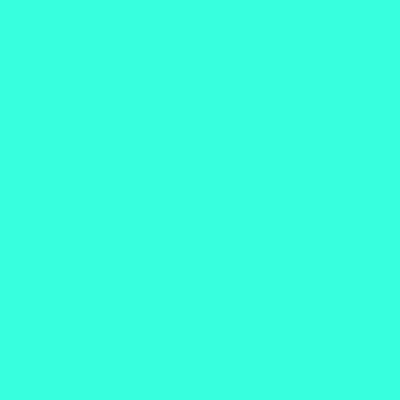
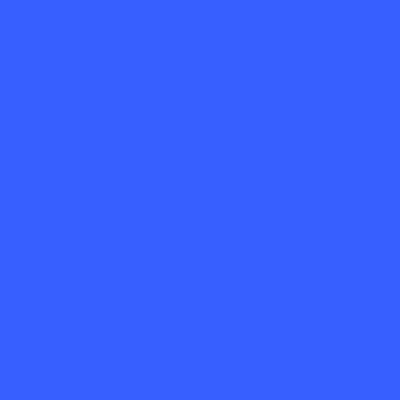
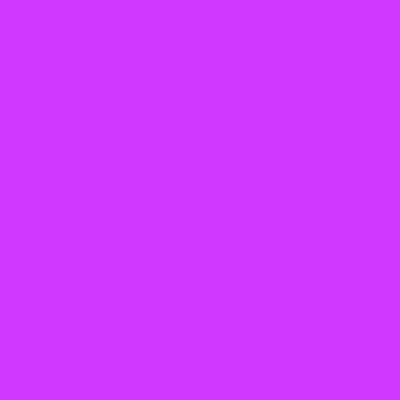
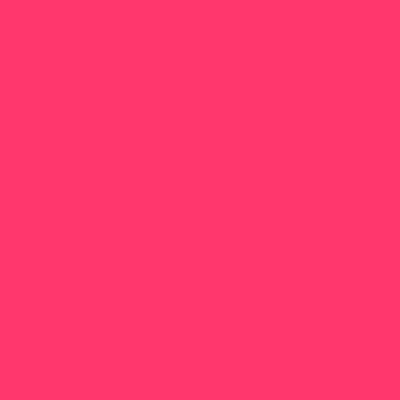
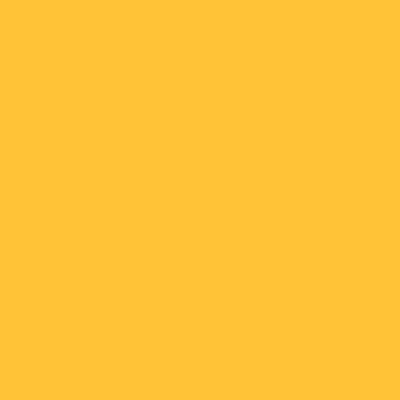
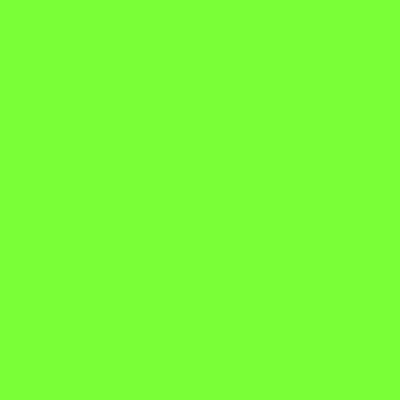
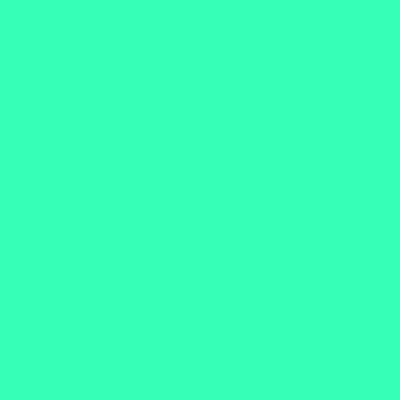
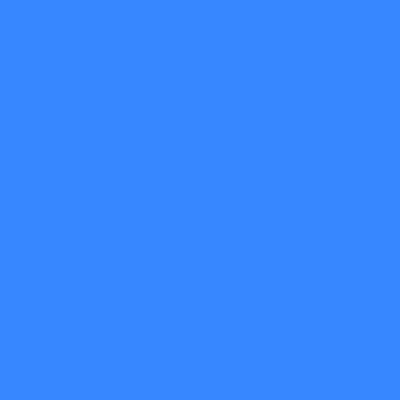
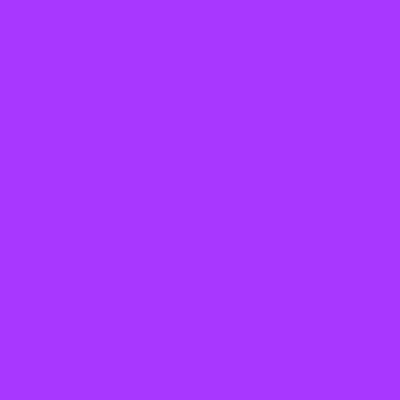
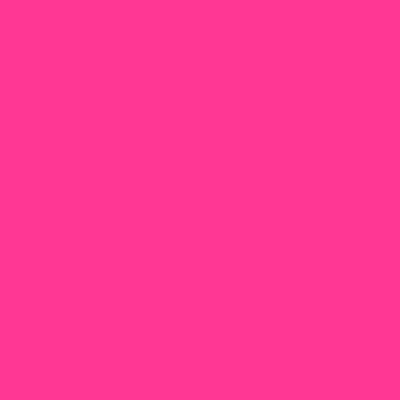
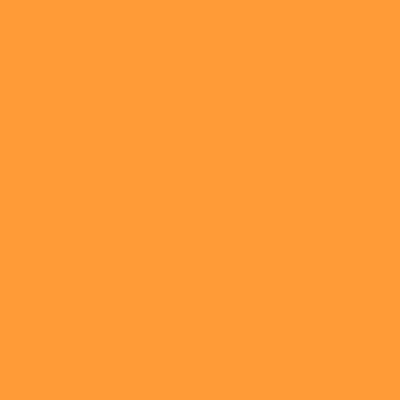
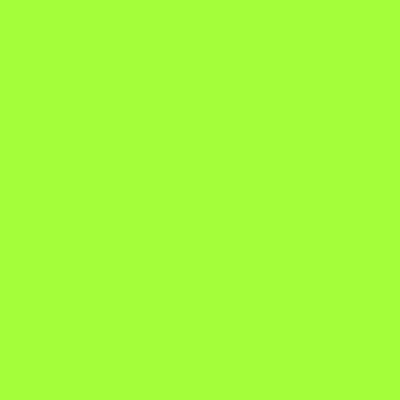
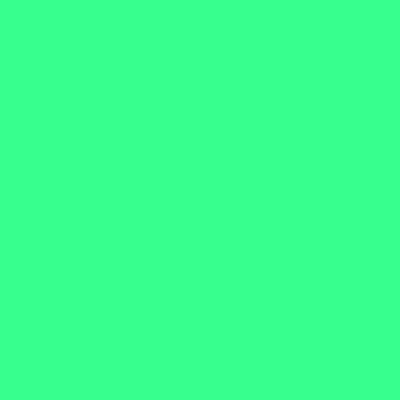
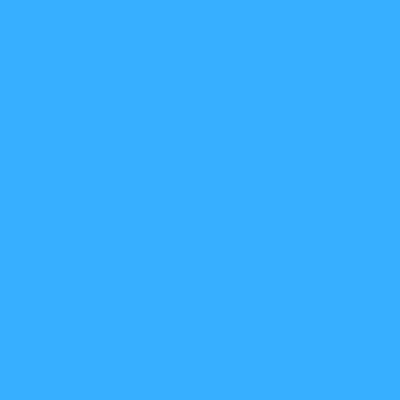
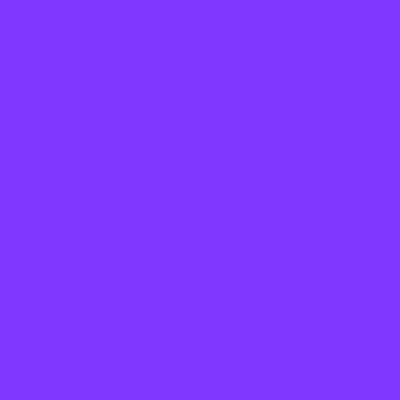

In [9]:
va.test_dnn_2(class_colors)
va.show(*[(np.array(c).reshape(1,1,3), str(i)) for i, c in enumerate(class_colors)], max_per_row=20)

Si analizzi ora il codice della funzione definita nella cella seguente: consente di disegnare un rettangolo su un'immagine con il colore corrispondente a una classe, scrivendo eventualmente il nome della classe e un valore di confidenza. Si osservi l'esempio di utilizzo nella cella seguente, eventualmente eseguendo dei test in altre celle, per comprenderne appieno il funzionamento.

In [10]:
def draw_object(img, class_index, confidence, rect, show_info):
    color, font, font_size = class_colors[class_index], cv.FONT_HERSHEY_PLAIN, 0.75
    x, y, w, h = rect    
    cv.rectangle(img, (x,y), (x+w,y+h), color, 2)    
    if show_info:
        name = class_names[class_index]
        (sx,sy), baseline = cv.getTextSize(name, font, font_size, 1)
        cv.rectangle(img, (x,y), (x+sx, y+sy*2+11), color, -1)
        cv.putText(img, name, (x,y+baseline+6), font, font_size, (0,0,0), lineType=cv.LINE_AA)
        cv.putText(img, f'{confidence:.0%}', (x,y+baseline+12+sy), font, font_size, (0,0,0), lineType=cv.LINE_AA)

""
""

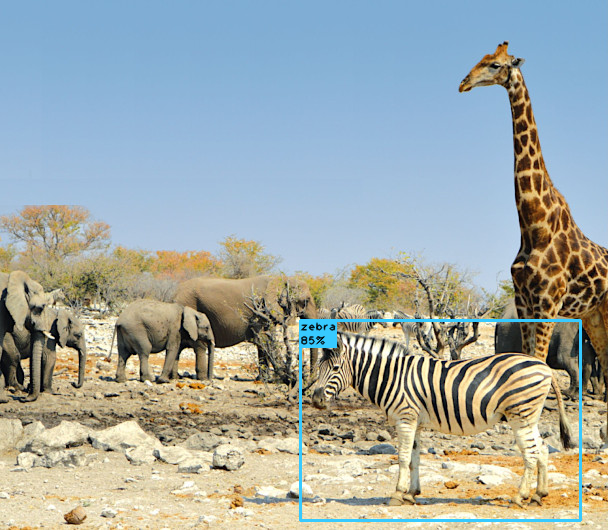

In [11]:
# Si supponga che all'interno dell'immagine "dnn/safari.jpg", un'oggetto della classe 22 (zebra) 
# sia stato individuato con confidenza del 85% nel rettangolo (300, 320, 280, 200).

img = cv.imread("dnn/safari.jpg")
draw_object(img, 22, 0.85, (300, 320, 280, 200), True)
va.show(img)

<img style="float:left" src="images/ar.png" />**Esercizio 3** - Come mostrato nelle dispense, per fornire un'immagine in ingresso alla rete, questa deve essere trasformata in un 'blob' mediante la funzione `cv.dnn.blobFromImage()`, che nel caso di Yolo dovrà essere chiamata con i parametri specificati nella cella seguente: fattore di scala pari a 1.0/255, dimensioni 320x320 e scambio dei canali R e B (la nostra immagine è in formato BGR, mentre la rete si aspetta RGB). Nel caso l'immagine non abbia le dimensioni 320x320, `cv.dnn.blobFromImage()` provvede a ridimensionarla, ma senza preservarne l'aspect ratio. Al fine di evitare deformazioni che potrebbero penalizzare l'accuratezza del riconoscimento, completare la funzione nella cella seguente, calcolando l'eventuale bordo da aggiungere orizontalmente (`border_w`) o verticalmente (`border_h`), in modo da rendere l'immagine `img` quadrata. Si noti che uno dei due valori `border_w` o `border_h` dovrà sempre essere zero: saranno entrambi zero solo se l'immagine è già quadrata. Creare quindi una nuova immagine `padded_img`, aggiungendo `border_w` pixel sia a sinistra che a destra e `border_h` pixel sia in alto che in basso: i pixel aggiunti dovranno essere neri.

In [12]:
# --- Svolgimento Esercizio 3: Inizio --- #

def prepare_input_blob(img):
    height,width=img.shape[:2]
    size=max(height,width)
    border_w = (size-width)//2
    border_h = (size-height)//2
    padded_img = cv.copyMakeBorder(img,border_h,size-height-border_h,
                                   border_w,size-width-border_w, cv.BORDER_CONSTANT)
   
    return border_w, border_h, padded_img.shape[0], cv.dnn.blobFromImage(padded_img, 1.0 / 255, (320, 320), swapRB = True)

# --- Svolgimento Esercizio 3: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente permette di visualizzare il contenuto del blob e di verificare che il suo contenuto sia esatto.

Dimensioni bordi,Contenuto blob
,


,,
,,

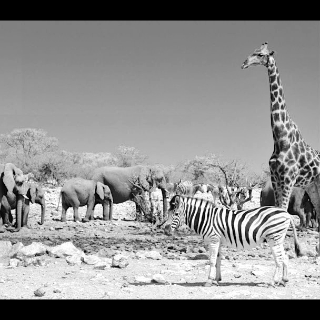
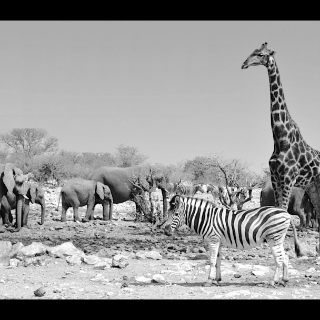
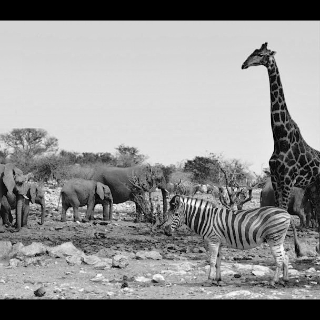

In [13]:
img = cv.imread("dnn/safari.jpg")
border_w, border_h, size, blob = prepare_input_blob(img)
va.test_dnn_3(border_w, border_h, blob)
va.show(*blob[0])

La cella seguente utilizza la funzione appena realizzata per predisporre l'immagine `img`, la fornisce in input alla rete ed esegue il passo di inferenza con il metodo `forward()`, per ottenere i corrispondenti output. La rete che stiamo utilizzando ha più di un livello di output: si noti come viene utilizzato il metodo `getUnconnectedOutLayersNames()` per ottenere i nomi di tali livelli, in modo da ottenere tutti i corrispondenti output. La cella stampa a video il nome di ciascun livello di output e la dimensione del corrispondente array con i valori di output.

In [14]:
border_w, border_h, size, blob = prepare_input_blob(img)    
net.setInput(blob)

out_names = net.getUnconnectedOutLayersNames()
out_values = net.forward(out_names)

for n, v in zip(out_names, out_values):
    print(f"L'output del livello {n} ha dimensioni {v.shape}")

L'output del livello yolo_82 ha dimensioni (300, 85)
L'output del livello yolo_94 ha dimensioni (1200, 85)
L'output del livello yolo_106 ha dimensioni (4800, 85)


I tre livelli di output della rete corrispondono a tre diverse scale, utilizzate per individuare oggetti di dimensioni differenti, come mostrato nella figura seguente.
![](dnn/scales.png)
Si noti che i "box" non corrispondono alle celle in cui è suddivisa l'immagine. Per ogni box (ossia un possibile rettangolo contenente un oggetto), gli 85 valori di output hanno il seguente significato:
* $t_x, t_y$: valori da cui si possono ricavare le coordinate del centro del box;
* $t_w, t_h$: valori da cui si possono ricavare larghezza e altezza del box;
* $p_o$: *objectness score*, probabilità che il box contenga effettivamente un oggetto;
* $s_0, s_1, ..., s_{79}$: *class scores*, probabilità che il box contenga un'oggetto della relativa classe.

Utilizzando YOLO con OpenCV, i valori $t_x, t_y, t_w, t_h$, che originariamente sono legati alle celle, vengono restituiti già modificati in modo da essere dei valori fra 0 e 1 relativi alle dimensioni dell'immagine: le coordinate in pixel di ciascun box possono essere quindi ottenute nello stesso modo per ciascuna scala, come mostrato nell'esempio seguente.
![](dnn/box.png)

<img style="float:left" src="images/ar.png" />**Esercizio 4** - Partendo dai risultati dell'esecuzione delle ultime celle, in particolare dal contenuto delle variabili `border_w`, `border_h`, `size`, `out_values`, si ottengano le seguenti informazioni dalla riga 231 del primo dei tre livelli di output della rete i cui valori sono già in `out_values`:
* `(x, y, w, h)`, coordinate in pixel del rettangolo relativamente alle dimensioni dell'immagine originale `img`;
* `class_index`, indice della classe che ha ottenuto lo score più elevato (dovrà risultare 22);
* `confidence`, lo score della classe.

Il procedimento è analogo a quanto mostrato nella figura precedente, con alcune differenze:
* la dimensione dell'immagine non è 320, ma è quanto contenuto nella variabile `size`;
* le coordinate `x, y` in questo caso non sono quelle del centro del rettangolo, ma del vertice in alto a sinistra;
* nell'ottenere il valore finale di `x, y`, si deve anche tenere conto che, per rendere l'immagine quadrata, era stato aggiunto un bordo (`border_w`, `border_h`) e le coordinate, per essere applicabili all'immagine originale, dovranno essere corrette di conseguenza.

Una volta ottenuti i valori richiesti, copiare `img` in una nuova immagine `res` e disegnare le informazioni sull'oggetto chiamando la funzione `draw_object()` definita in precedenza.

In [15]:
# --- Svolgimento Esercizio 4: Inizio --- #

#prendiamo la riga 231 a livello 0
box=out_values[0][231]
#classe con indice più elevato
class_index=np.argmax(box[5:])
x, y, w, h = (box[:4]*size).round().astype(int)

#mi interessano le coordinate del punto in alto a sinistra, gli tolgo anche l'eventuale
#bordo aggiunto
x-=(w//2+border_w)
y-=(h//2+border_h)
#+5 perchè ho 5 valori prima
confidence = float(box[5+class_index])

res = img.copy()
#true perchè voglio visualizzare tutto
draw_object(res,class_index,confidence,(x,y,w,h),True)



# --- Svolgimento Esercizio 4: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente visualizza il risultato ottenuto a fianco di quello corretto.

Risultato ottenuto,Risultato atteso
,

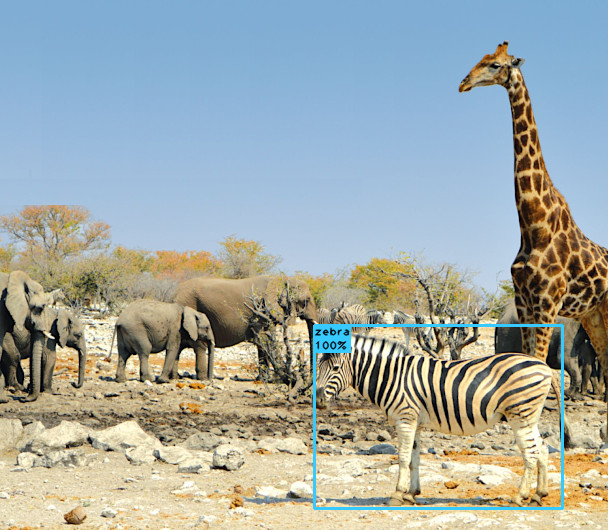
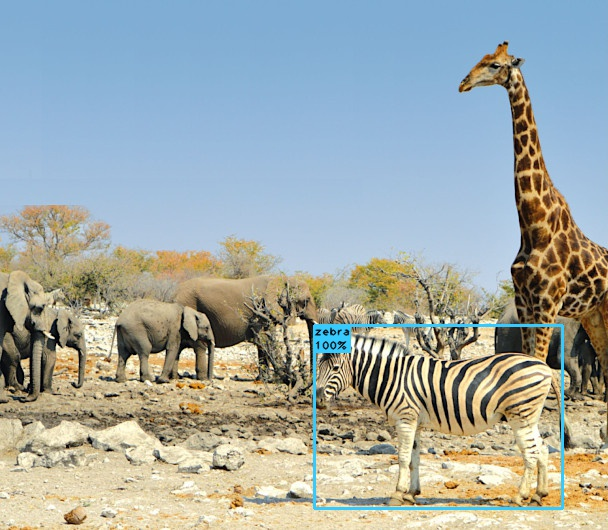

In [12]:
va.show((res, 'Risultato ottenuto'), (cv.imread('dnn/res_4.jpg'), 'Risultato atteso'))

<img style="float:left" src="images/ar.png" />**Esercizio 5** - Grazie all'esperienza maturata negli esercizi precedenti, completare la funzione `yolo_detection(image, conf_threshold)` che, ricevuti in input un'immagine e una soglia fra 0 e 1:
* prepara l'input per la rete utilizzando `prepare_input_blob()`;
* esegue la rete neurale su tale input;
* analizza quanto ottenuto dai 3 livelli di output e, restituisce tre liste `class_indices`, `confidences`, `detected_objects`, contenenti, rispettivamente, gli indici delle classi, gli score e i rettangoli (tuple x, y, w, h) di tutti i box che hanno uno score maggiore o uguale a `conf_threshold`. Per ogni box considerare solo lo score con valore massimo.

In [13]:


#sono gli indici delle classi
out= out_values[0]
i_max=np.argmax(out[:,5:],axis=1)
i_max, i_max.shape
#ora devo prendere i valori che superano la soglia
#trovo gli indici di quelle righe(box) in cui il massimo orizzontale supera la soglia
#[0] per prendere il valore della tupla restituita da nonzero
row_indices=np.nonzero(out[np.arange(i_max.shape[0]),5+i_max]>=0.4)[0]
#sono i primi 4 valori delle righe che soddisfano le condizioni
rects=(out[row_indices,:4]*size).round().astype(int)
#metto in un unico vettore per togliere x-=(w//2+border_w), y-=(h//2+border_h)

border=np.array((border_w,border_h))
#per tutte le rige selezionate faccio le operazioni x-=(w//2+border_w), y-=(h//2+border_h)
rects[:,:2]-=(rects[:,2:]//2+border)
#devo fare la stessa cosa ma solo per le righe selezionate
indices=i_max[row_indices]
indices
#lo score dei soli indici filtrati
scores=out[row_indices,indices+5]
scores


array([0.9982332, 0.9992402], dtype=float32)

In [14]:
# --- Svolgimento Esercizio 5: Inizio --- #

def yolo_detection(image, conf_threshold):
    #preparo la rete
    border_w, border_h, size, blob = prepare_input_blob(image)
    #metto in un unico vettore per togliere x-=(w//2+border_w), y-=(h//2+border_h)
    border=np.array((border_w,border_h))
    net.setInput(blob)
    out_values=net.forward(out_names)
    
    class_indices, confidences, detected_objects = [], [], []    
    for out in out_values:
        #su ogni riga cerco il massimo partendo dalla colonna 5
        i_max=np.argmax(out[:,5:],axis=1)
        row_indices=np.nonzero(out[np.arange(i_max.shape[0]),5+i_max]>=conf_threshold)[0]
        rects=(out[row_indices,:4]*size).round().astype(int)
        rects[:,:2]-=(rects[:,2:]//2+border)
        indices=i_max[row_indices]
        scores=out[row_indices,indices+5]
        
        class_indices+=indices.tolist()
        confidences+=scores.tolist()
        detected_objects+=rects.tolist()
    return class_indices, confidences, detected_objects

# --- Svolgimento Esercizio 5: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente visualizza il risultato ottenuto a fianco di quello corretto. Si noti che la giraffa viene individuata due volte, a due scale differenti: questo problema verrà affrontato nel prossimo esercizio.

Risultato ottenuto,Risultato atteso
,

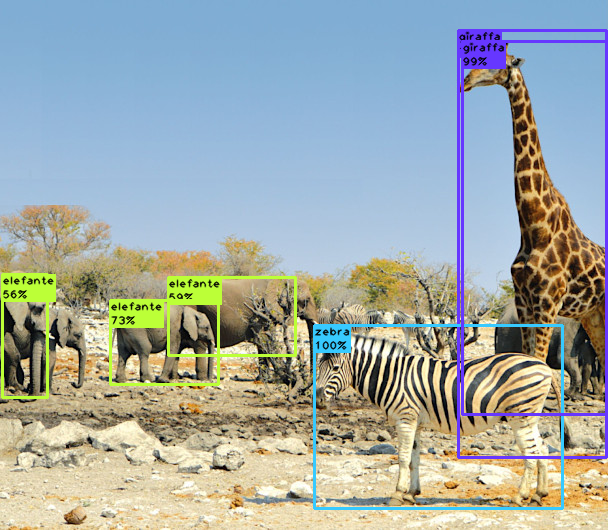
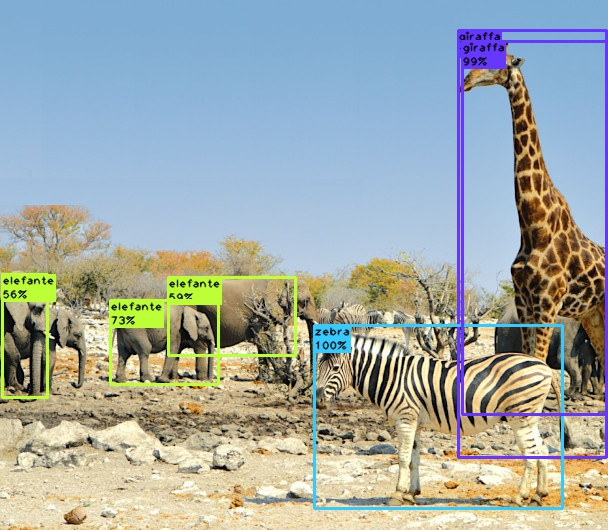

In [15]:
res = img.copy()
for i, c, r in zip(*yolo_detection(img, 0.4)):
    draw_object(res, i, c, r, True)
va.show((res, 'Risultato ottenuto'), (cv.imread('dnn/res_5.jpg'), 'Risultato atteso'))

<img style="float:left" src="images/ar.png" />**Esercizio 6** - Implementare una nuova funzione `yolo_detection_nms(image, conf_threshold, nms_threshold)` che si comporti in modo analogo a `yolo_detection()`, ma applichi anche la funzione OpenCV `cv.dnn.NMSBoxes()` per filtrare i risultati di `yolo_detection()`, eliminando oggetti che si sovrappongono troppo (rispetto alla soglia `nms_threshold`) ad altri oggetti con valore di confidenza maggiore. Prestare attenzione al valore di ritorno di `cv.dnn.NMSBoxes()`: l'array di indici che restituisce ha una dimensione a 1 "di troppo". Inoltre è necessario gestire anche il caso in cui nessun oggetto soddisfi i criteri: in tal caso `cv.dnn.NMSBoxes()` restituisce una tupla vuota invece di un array NumPy: verificare che questo non crei problemi alla implementazione proposta.

In [ ]:
#la giraffa la trova due volte perchè a due scale differenti

In [16]:
# --- Svolgimento Esercizio 6: Inizio --- #

def yolo_detection_nms(image, conf_threshold, nms_threshold):
    class_indices, confidences, detected_objects=yolo_detection(image,conf_threshold)
    #ravel compatta in una dimensione
    indices=np.ravel(cv.dnn.NMSBoxes(detected_objects,confidences,conf_threshold,nms_threshold))
    
    class_indices=[class_indices[i] for i in indices]
    confidences=[confidences[i] for i in indices]
    detected_objects=[detected_objects[i] for i in indices]
    
    return class_indices, confidences, detected_objects
    
    # --- Svolgimento Esercizio 6: Fine --- #

<img style="float:left" src="images/in.png" />La cella seguente consente di provare la funzione su alcune immagini variando i parametri: assicurarsi che il risultato sia ragionevole e non ci siano errori di esecuzione anche nei casi limite (soglie a zero o a uno).

In [17]:
@interact(image_name=['safari', 'cd', 'el', 'tb', 'cb', 'mc', 'spam'], 
        conf_threshold = (0,1,0.1), nms_threshold = (0,1,0.1), info = True)
def test_yolo(image_name = 'safari', conf_threshold = 0.4, nms_threshold = 0.5, info = True):
    img = cv.imread(f'dnn/{image_name}.jpg')
    for i, c, r in zip(*yolo_detection_nms(img, conf_threshold, nms_threshold)):
        draw_object(img, i, c, r, info)
    va.show(img)

interactive(children=(Dropdown(description='image_name', options=('safari', 'cd', 'el', 'tb', 'cb', 'mc', 'spa…